# Predicting segments with model
### October 12th 2018
* This demo goes through loading a previously computed model and predicting masks. 
* It is set up to use the validation images but you can put in any images (as long as they are 256x256). 

### Import modules

In [25]:
import os
from itertools import izip

# learning modules
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import models
from tensorflow.python.keras import losses

# plotting modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

# Make image generator
* You don't have to use a generator, but it can make processing a bunch of images easier.
* Since there is no augmentation, none of the parameters need to be specified for ImageDataGenerator.
* Important to turn shuffle off for predicting or else the images don't come out in the same order. 

In [26]:
data_dir = './demo/data'

In [27]:
# for the validation data we do no augmentation
val_image_datagen = ImageDataGenerator()

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
batch_size = 1

val_image_generator = val_image_datagen.flow_from_directory(
    os.path.join(data_dir, 'val/images'),
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size,
    shuffle=False)

Found 40 images belonging to 1 classes.


# Load model
* Supply it with the custom loss objects with which it was trained.
* The model is nearly 200Mb. It is too big to put on github but you can get it from [this](https://www.evernote.com/shard/s270/nl/69190255/8c087944-54ea-4eff-bf1a-3c346fbbcba6/) Evernote note. 

In [28]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [29]:
model = models.load_model('./demo/weights.hdf5', 
                          custom_objects={'bce_dice_loss': bce_dice_loss,
                                          'dice_loss': dice_loss})

# Predict on all images in generator

In [30]:
# here are some arguments for multiprocessing if you want
# args = dict(steps=val_image_generator.n / val_image_generator.batch_size,
#             max_queue_size=10,
#             workers=4,
#             use_multiprocessing=True,
#             verbose=1)

predictions = model.predict_generator(val_image_generator, verbose=1)

40/40 [==============================] - 22s 545ms/step


### Predict on one batch
* Alternative method to just do batch at a time.

In [31]:
# test_imgs = val_image_generator.next() # the next command produces a new batch of images
# predictions = model.predict_on_batch(test_imgs)

# Save out predicions overlaid on the images
* The output is a probability map where each pixel ranges from 0 to 1. We simply take a threshold of 0.99 to label a pixel as a cell.

In [32]:
image_output_path = './demo/output/'

try:
    os.makedirs(image_output_path)
except:
    print(image_output_path, 'already exists.')

('./demo/output/', 'already exists.')


//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


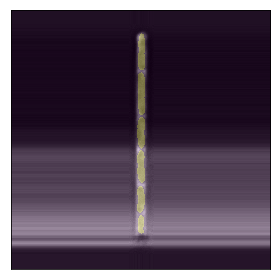

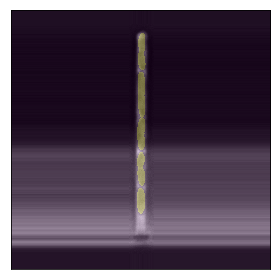

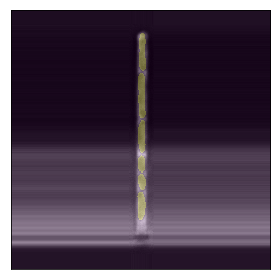

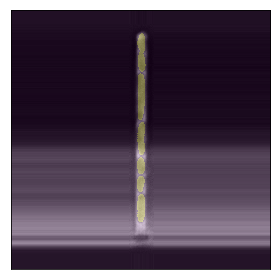

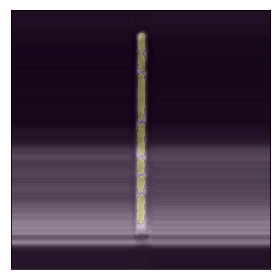

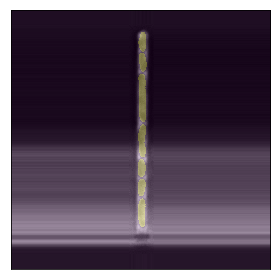

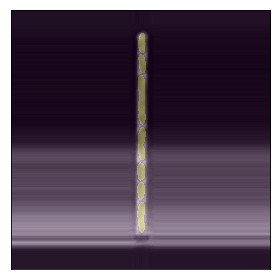

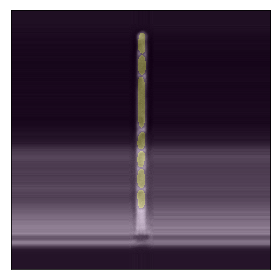

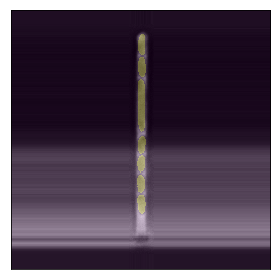

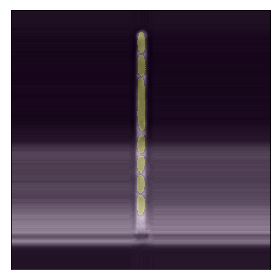

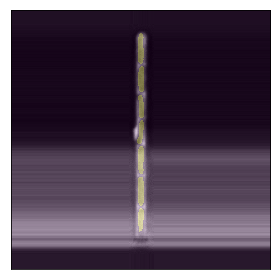

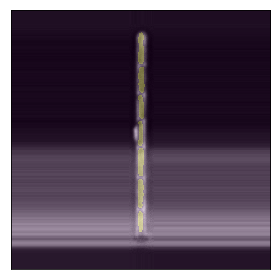

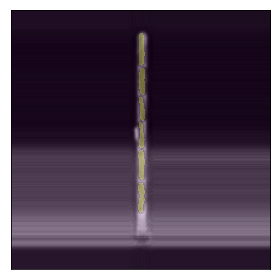

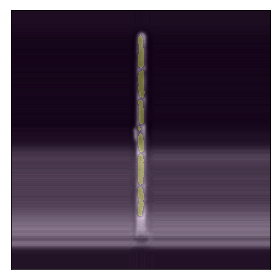

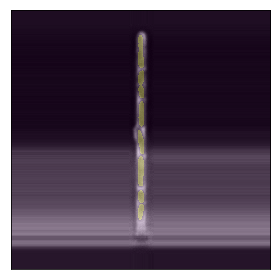

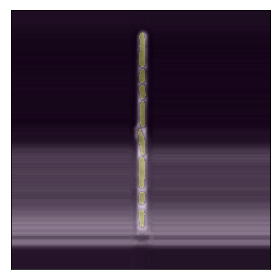

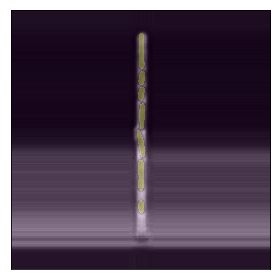

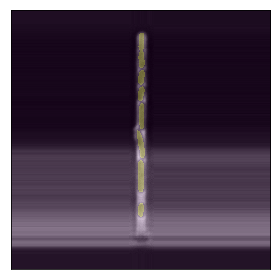

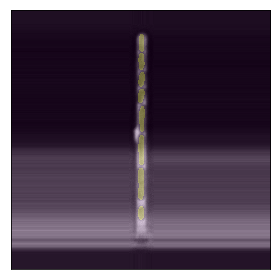

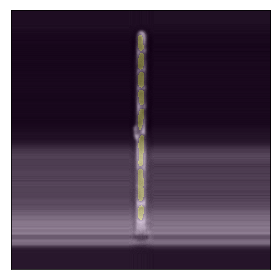

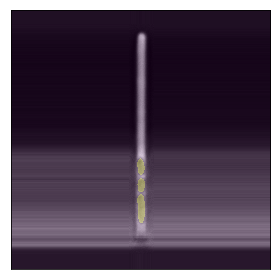

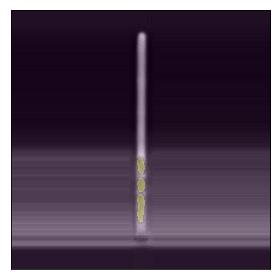

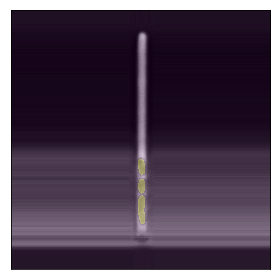

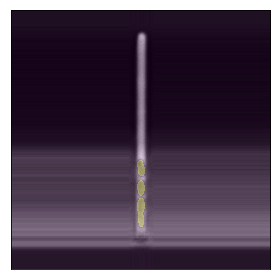

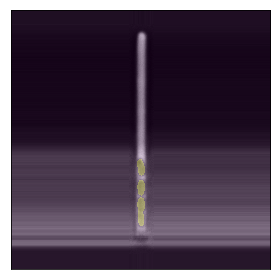

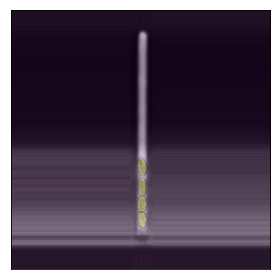

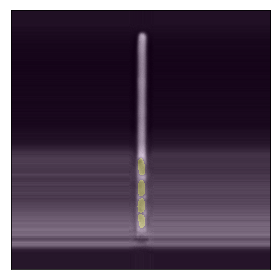

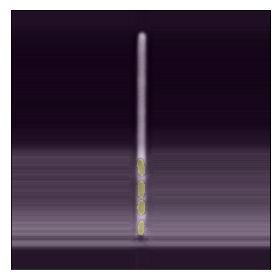

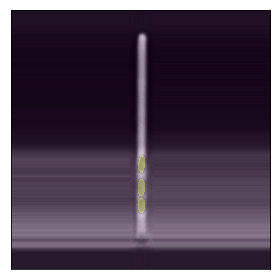

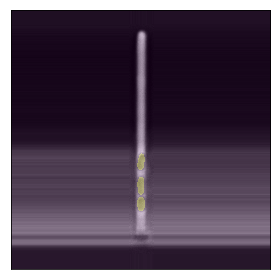

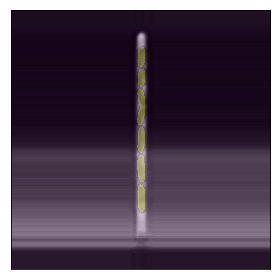

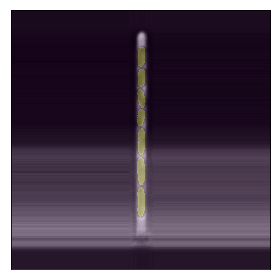

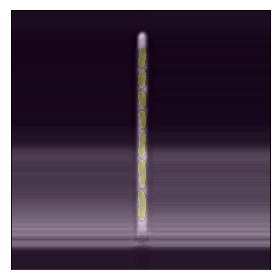

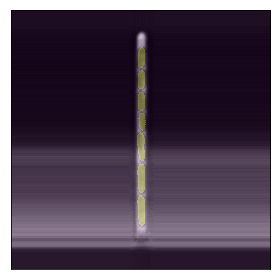

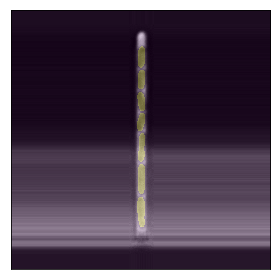

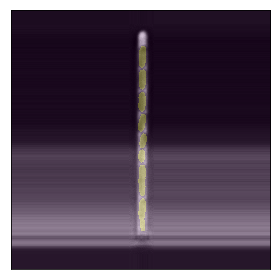

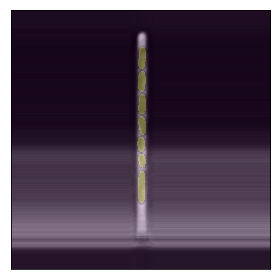

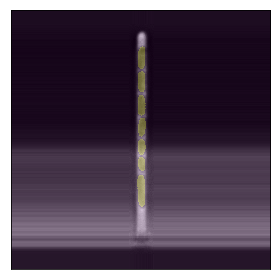

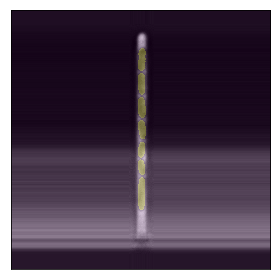

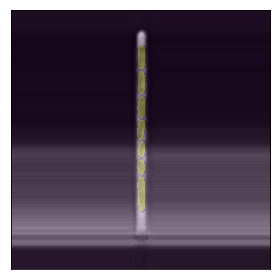

In [35]:
val_image_generator.reset() # start generator over
n_imgs = predictions.shape[0]
for i in range(n_imgs):

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4), squeeze=False)
    ax = axes.ravel()

    img = val_image_generator.next()[0,:,:,0]
    predicted_label = predictions[i,:,:,0]
    predicted_label[predicted_label >= 0.99] = 1
    predicted_label[predicted_label < 0.99] = 0

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].imshow(predicted_label, alpha=0.25)

    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    
    fig.tight_layout()
    fig.savefig(os.path.join(image_output_path, '{:02d}.png'.format(i)), dpi=200)
    
    fig.show()  
        